To run this notebook, you will need to either have Madrigal-LLM trained in your own environment, or download corresponding checkpoints and data from [here](https://drive.google.com/drive/folders/1U7xMEoopJu237k_FGpJUjemd0GcF-Q8l?usp=sharing) and save it as `{Madrigal_Data}/model_output/lm_decoder`.

In [1]:
import pandas as pd
import numpy as np
import os

from madrigal.evaluate.metrics import get_metrics
from madrigal.utils import DATA_DIR, BASE_DIR

from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

['str', 'kg', 'cv']


In [2]:
description_df = pd.read_csv(os.path.join(DATA_DIR, 'polypharmacy_new/DrugBank/drugbank_ddi_directed_final_cleaned.tsv'))
runs_mistral_no_para = ['autumn-water-105', 'eternal-cherry-106', 'curious-cosmos-104']
runs_mistral = ['restful-fire-101', 'glorious-deluge-103', 'light-silence-102']
epoch = 6

In [3]:
desc = ['Analgesic, increase',
           'Bioavailability, increase',
           'Thrombocytopenia and bleeding, increase',
            'Gastrointestinal bleeding, increase',
            'Gastrointestinal ulceration and irritation, increase',
            'Hypertension, increase',
            'Hypertension and tardive dyskinesia, increase',
            'Hypotension and electrolyte disturbance, increase',
            'Methemoglobinemia, increase',
            'Nephrotoxicity, increase',
            'Neuroexcitatory, increase',
            'Renal failure, hypotension, increase',
            'Sedation, decrease',
            'Serum level of the active metabolites and efficacy, decrease',
            'Serum level of the active metabolites, increase',
            'Thrombocytopenia, increase'
           ]
new_desc = []
for de in desc:
    de = de.replace(", increase", " \u2191")
    de = de.replace(", decrease", " \u2193")
    new_desc.append(de)

## Baseline

In [4]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

device = 'cuda'

lm_model = 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext'
tokenizer =  BertTokenizer.from_pretrained(lm_model)

model = BertModel.from_pretrained(lm_model).to(device)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

/n/data1/hms/dbmi/zitnik/lab/users/yeh803/Archived/miniforge3/envs/madrigal_env/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def get_label_embeddings(split):
    df = pd.read_csv(BASE_DIR+f'model_output/lm_decoder/paraphrased_dataset_new/{split}_df.csv') 
    
    label_descriptions = np.unique(df['label_descriptions'].values)
    labels = np.unique(df['labels'])

    example_encoding = tokenizer.batch_encode_plus(
    label_descriptions.tolist(),
    padding=True,
    return_tensors='pt',
    add_special_tokens=True)
    
    example_input_ids = example_encoding['input_ids'].to(device)
    example_attention_mask = example_encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        example_outputs = model(example_input_ids, attention_mask=example_attention_mask)
        example_sentence_embedding = example_outputs.last_hidden_state[:,0,:].cpu().numpy()
    
    return example_sentence_embedding, label_descriptions, labels, df

In [6]:
train_embeddings, label_train_descriptions, labels_train, train_df = get_label_embeddings('train')
eval_embeddings, label_eval_descriptions, labels_eval, eval_df = get_label_embeddings('eval')
similarity_score = cosine_similarity(train_embeddings, eval_embeddings)

In [7]:
train_df_pos = train_df[train_df['pos_neg'] == 1]
num_pos = train_df_pos.shape[0]

label_mapping = {}

for i in range(label_eval_descriptions.shape[0]):
    sims = similarity_score[:,i]
    top_k = sims.argsort()[::-1][:3]
    
    top_train_label_desc = [label_train_descriptions[j] for j in top_k]
    train_df_subset = train_df_pos[train_df_pos['label_descriptions'].isin(top_train_label_desc)]
    
    train_df_rev = train_df_subset.copy()
    train_df_rev['head'], train_df_rev['tail'] = train_df_subset['tail'], train_df_subset['head']
    
    train_df_new = pd.concat([train_df_subset, train_df_rev], ignore_index=True)
    
    drug_scores = {}

    for drug in tqdm(train_df_new['head'].unique()):
        score = train_df_new[train_df_new['head'] == drug]['pos_neg'].shape[0]
        drug_scores[drug] = score/num_pos 
    
    label_mapping[label_eval_descriptions[i]] = drug_scores

100%|██████████| 220/220 [00:00<00:00, 5593.39it/s]


In [8]:
label_naive_scores = []

for i in tqdm(range(eval_df.shape[0])):
    
    drug_1 = eval_df.loc[eval_df.index[i], 'head']
    drug_2 = eval_df.loc[eval_df.index[i], 'tail']
    label = eval_df.loc[eval_df.index[i], 'label_descriptions']
    
    label_idx = eval_df.loc[eval_df.index[i], 'labels']
    
    drug_scores = label_mapping[label]
    
    try:
        drug_score_1 = drug_scores[drug_1]
    except:
        drug_score_1 = 0
    
    try:
        drug_score_2 = drug_scores[drug_2]
    except:
        drug_score_2 = 0
    
    label_naive_scores.append((drug_score_1 + drug_score_2)/2)
    

100%|██████████| 266208/266208 [00:05<00:00, 47249.65it/s]


In [9]:
labels = eval_df['labels'].values
unique_labels = np.unique(labels)
pos_neg = eval_df['pos_neg'].values

test_metrics_naive, _ = get_metrics(
    np.array(label_naive_scores), 
    pos_neg, 
    labels, 
    k=50, 
    task='multiclass', 
    average=None, 
    logger=None, 
    verbose=False, 
)

/n/data1/hms/dbmi/zitnik/lab/users/yeh803/Archived/miniforge3/envs/madrigal_env/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/n/data1/hms/dbmi/zitnik/lab/users/yeh803/Archived/miniforge3/envs/madrigal_env/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [12]:
np.save('./naive_metrics.npy', test_metrics_naive)

## Madrigal label stratified perfromance (1)

In [ ]:
eval_df_normal = pd.read_csv(BASE_DIR+'model_output/lm_decoder/dataset/eval_df.csv')

labels = eval_df_normal['labels'].values
unique_desc_df = description_df.drop_duplicates(subset='label_indexed')
label_to_desc = dict(zip(unique_desc_df['label_indexed'].values, 
                         unique_desc_df['label'].values))
unique_labels_desc = [label_to_desc[l] for l in np.unique(labels)]
eval_df = pd.read_csv(BASE_DIR+'model_output/lm_decoder/paraphrased_dataset_new/eval_df.csv')

epoch = 6

In [ ]:
def sig(x):
    return 1/(1 + np.exp(-x))

def get_auprc(run, epoch, eval_df):
    labels = eval_df['labels'].values
    unique_labels = np.unique(labels)
    pos_neg = eval_df['pos_neg'].values
    all_test_metrics = []
    for i in tqdm(range(10)):
        eval_preds = np.load(BASE_DIR+f'model_output/lm_decoder/{run}/eval_raw_scores_{epoch}_description_{i}.npy')
        test_metrics, _ = get_metrics(
        sig(eval_preds), 
        pos_neg, 
        labels, 
        k=50, 
        task='multiclass', 
        average=None, 
        logger=None, 
        verbose=False)
        unique_labels_desc = [label_to_desc[l] for l in unique_labels]
        all_test_metrics.append([test_metrics['auprc']])
    return np.squeeze(np.array(all_test_metrics)), unique_labels_desc

metrics_repeat_mistral = []
for run in runs_mistral:
    metrics, desc = get_auprc(run, epoch, eval_df)
    metrics_repeat_mistral.append(metrics)

100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


In [15]:
metrics_repeat_mistral = np.array(metrics_repeat_mistral)

In [ ]:
def get_auprc_no_para(run, epoch, eval_df):
    labels = eval_df['labels'].values
    unique_labels = np.unique(labels)
    pos_neg = eval_df['pos_neg'].values
    
    all_test_metrics = []
    
    eval_preds = np.load(BASE_DIR+f'model_output/lm_decoder/{run}/eval_raw_scores_{epoch}.npy')
    test_metrics, _ = get_metrics(
    sig(eval_preds), 
    pos_neg, 
    labels, 
    k=50, 
    task='multiclass', 
    average=None, 
    logger=None, 
    verbose=False)
    unique_labels_desc = [label_to_desc[l] for l in unique_labels]
    all_test_metrics.append([test_metrics['auprc']])
    return np.squeeze(np.array(all_test_metrics)), unique_labels_desc

normal_metrics_repeat_mistral = []
for run in runs_mistral_no_para:
    metrics, normal_desc = get_auprc_no_para(run, epoch, eval_df_normal)
    normal_metrics_repeat_mistral.append(metrics)

/n/data1/hms/dbmi/zitnik/lab/users/yeh803/Archived/miniforge3/envs/madrigal_env/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [17]:
normal_metrics_repeat_mistral = np.array(normal_metrics_repeat_mistral)

In [18]:
np.concatenate([
        normal_metrics_repeat_mistral.reshape(48),
        metrics_repeat_mistral[:,0,:].reshape(48),
        test_metrics_naive["auprc"],
    ]).shape

(112,)

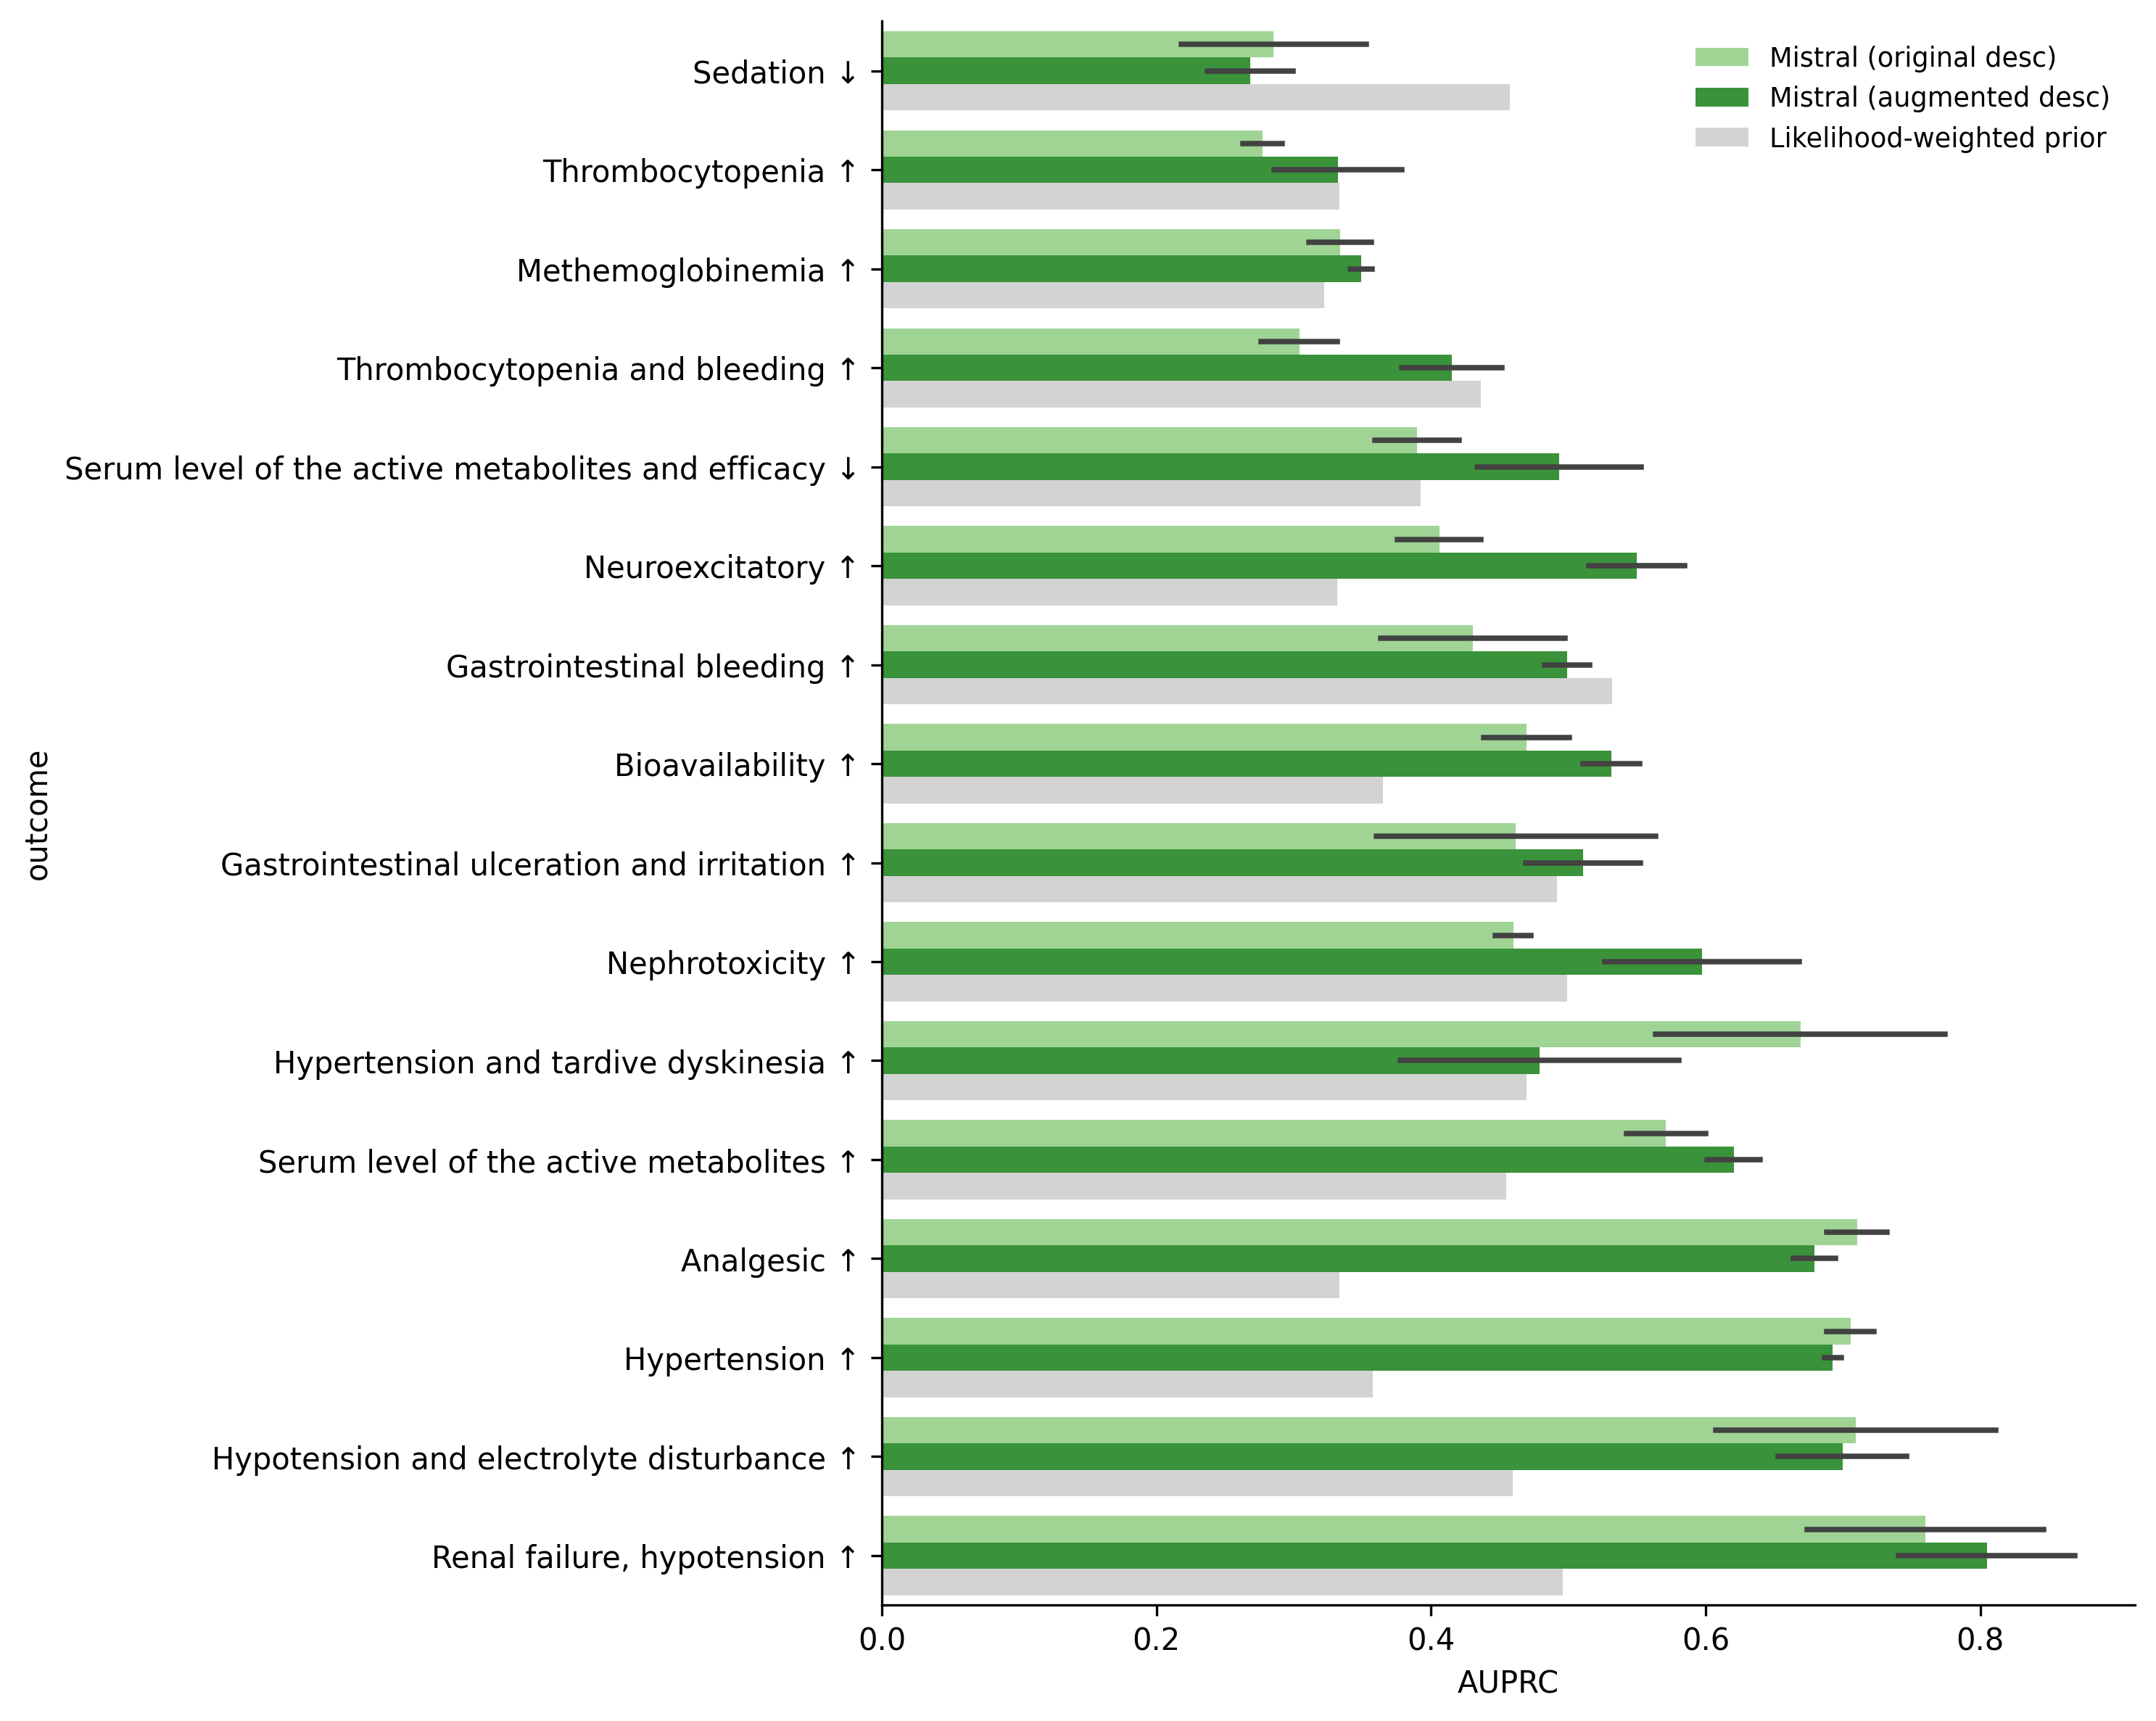

In [ ]:
from matplotlib.pyplot import figure
%matplotlib inline

figure(figsize=(10, 8), dpi=300)

df_1 = pd.DataFrame.from_dict({
    'AUPRC': np.concatenate([
        normal_metrics_repeat_mistral.reshape(48),
        metrics_repeat_mistral[:,0,:].reshape(48),
        test_metrics_naive["auprc"],
    ]),
    'outcome': np.concatenate([new_desc]*7),
    'label': ['Mistral (original desc)']*48 + \
        ['Mistral (augmented desc)']*48 + \
        ["Likelihood-weighted prior"]*16
})

# df_1.to_csv('./plot_5a_new.csv')

result = df_1.groupby(["outcome"])['AUPRC'].aggregate(np.mean).reset_index().sort_values('AUPRC')

ax = plt.axes()
ax.set_facecolor("white")

sns.set_context(context='paper')
# Create a custom color palette where models with the same base share similar colors
palette = {
    'Mistral (augmented desc)': '#2ca02c',        # Green
    'Mistral (original desc)': '#98df8a',        # Light green
    'Likelihood-weighted prior': '#d3d3d3',  # Light gray
}
g = sns.barplot(
    data=df_1,
    errorbar="sd",
    x="AUPRC", y="outcome", hue="label", order=result['outcome'], palette=palette,)
sns.despine()
plt.legend(frameon=False, loc = "best")
plt.tight_layout()

# plt.savefig('./performance_augmented_vs_normal_rep_sns.pdf')

## Madrigal label stratified perfromance (2)

In [ ]:
eval_df = pd.read_csv(BASE_DIR+'model_output/lm_decoder/paraphrased_dataset_new/eval_df.csv')
labels = eval_df['labels'].values
unique_desc_df = description_df.drop_duplicates(subset='label_indexed')
label_to_desc = dict(zip(unique_desc_df['label_indexed'].values, 
                         unique_desc_df['label'].values))
unique_labels_desc = [label_to_desc[l] for l in np.unique(labels)]

In [ ]:
def sig(x):
    return 1/(1 + np.exp(-x))

def sort_three(arr1, arr2, arr3, col=0):
    arg_sort = arr1[:,col].argsort()
    return arr1[arg_sort,:], np.array(arr2)[arg_sort], np.array(arr3)[arg_sort,:]

def sort_four(arr1, arr2, arr3, arr4, col=0):
    arg_sort = arr1[:,col].argsort()
    return arr1[arg_sort,:], np.array(arr2)[arg_sort], np.array(arr3)[arg_sort,:], np.array(arr4)[arg_sort,:]

def get_auprc(run, epoch, eval_df):
    labels = eval_df['labels'].values
    unique_labels = np.unique(labels)
    pos_neg = eval_df['pos_neg'].values
    
    all_test_metrics = []
    
    for i in tqdm(range(10)):
        eval_preds = np.load(BASE_DIR+f'model_output/lm_decoder/{run}/eval_raw_scores_{epoch}_description_{i}.npy')
        test_metrics, _ = get_metrics(
            sig(eval_preds), 
            pos_neg, 
            labels, 
            k=50, 
            task='multiclass', 
            average=None, 
            logger=None, 
            verbose=False)
        unique_labels_desc = [label_to_desc[l] for l in unique_labels]
        all_test_metrics.append([test_metrics['auprc']])
    return np.squeeze(np.array(all_test_metrics)), unique_labels_desc

def plot_stratified(runs, epoch, eval_df, test_metrics_naive=None):
    
    all_auprc_repeat = []
    
    for run in runs:
        all_auprc, unique_labels_desc = get_auprc(run, epoch, eval_df)
        all_auprc_repeat.append(all_auprc)
        
    all_auprc_repeat = np.array(all_auprc_repeat)
    
    return all_auprc_repeat

In [22]:
all_auprc_repeat = plot_stratified(runs_mistral, epoch, eval_df, test_metrics_naive['auprc'])

100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


In [23]:
dfs = []
for i in range(3):
    
    label = ['Original description']*16 + ['Medical doctor']*48 + ['Pharmacologist']*48 + ['Toxicologist']*48
    
    dfs.append(pd.DataFrame({'AUPRC': all_auprc_repeat[i,:,:].reshape(160),
                     'Outcome': np.concatenate([new_desc]*10),
                    'label': label}))

In [24]:
naive_df = pd.DataFrame({'AUPRC': test_metrics_naive['auprc'],
                         'Outcome': new_desc,
                         'label': ['Naive baseline']*16})
df_2 = pd.concat(dfs + [naive_df])
# df_2.to_csv('./plot_5b.csv')

In [ ]:
# df_2 = pd.read_csv('./plot_5b.csv', index_col=0)

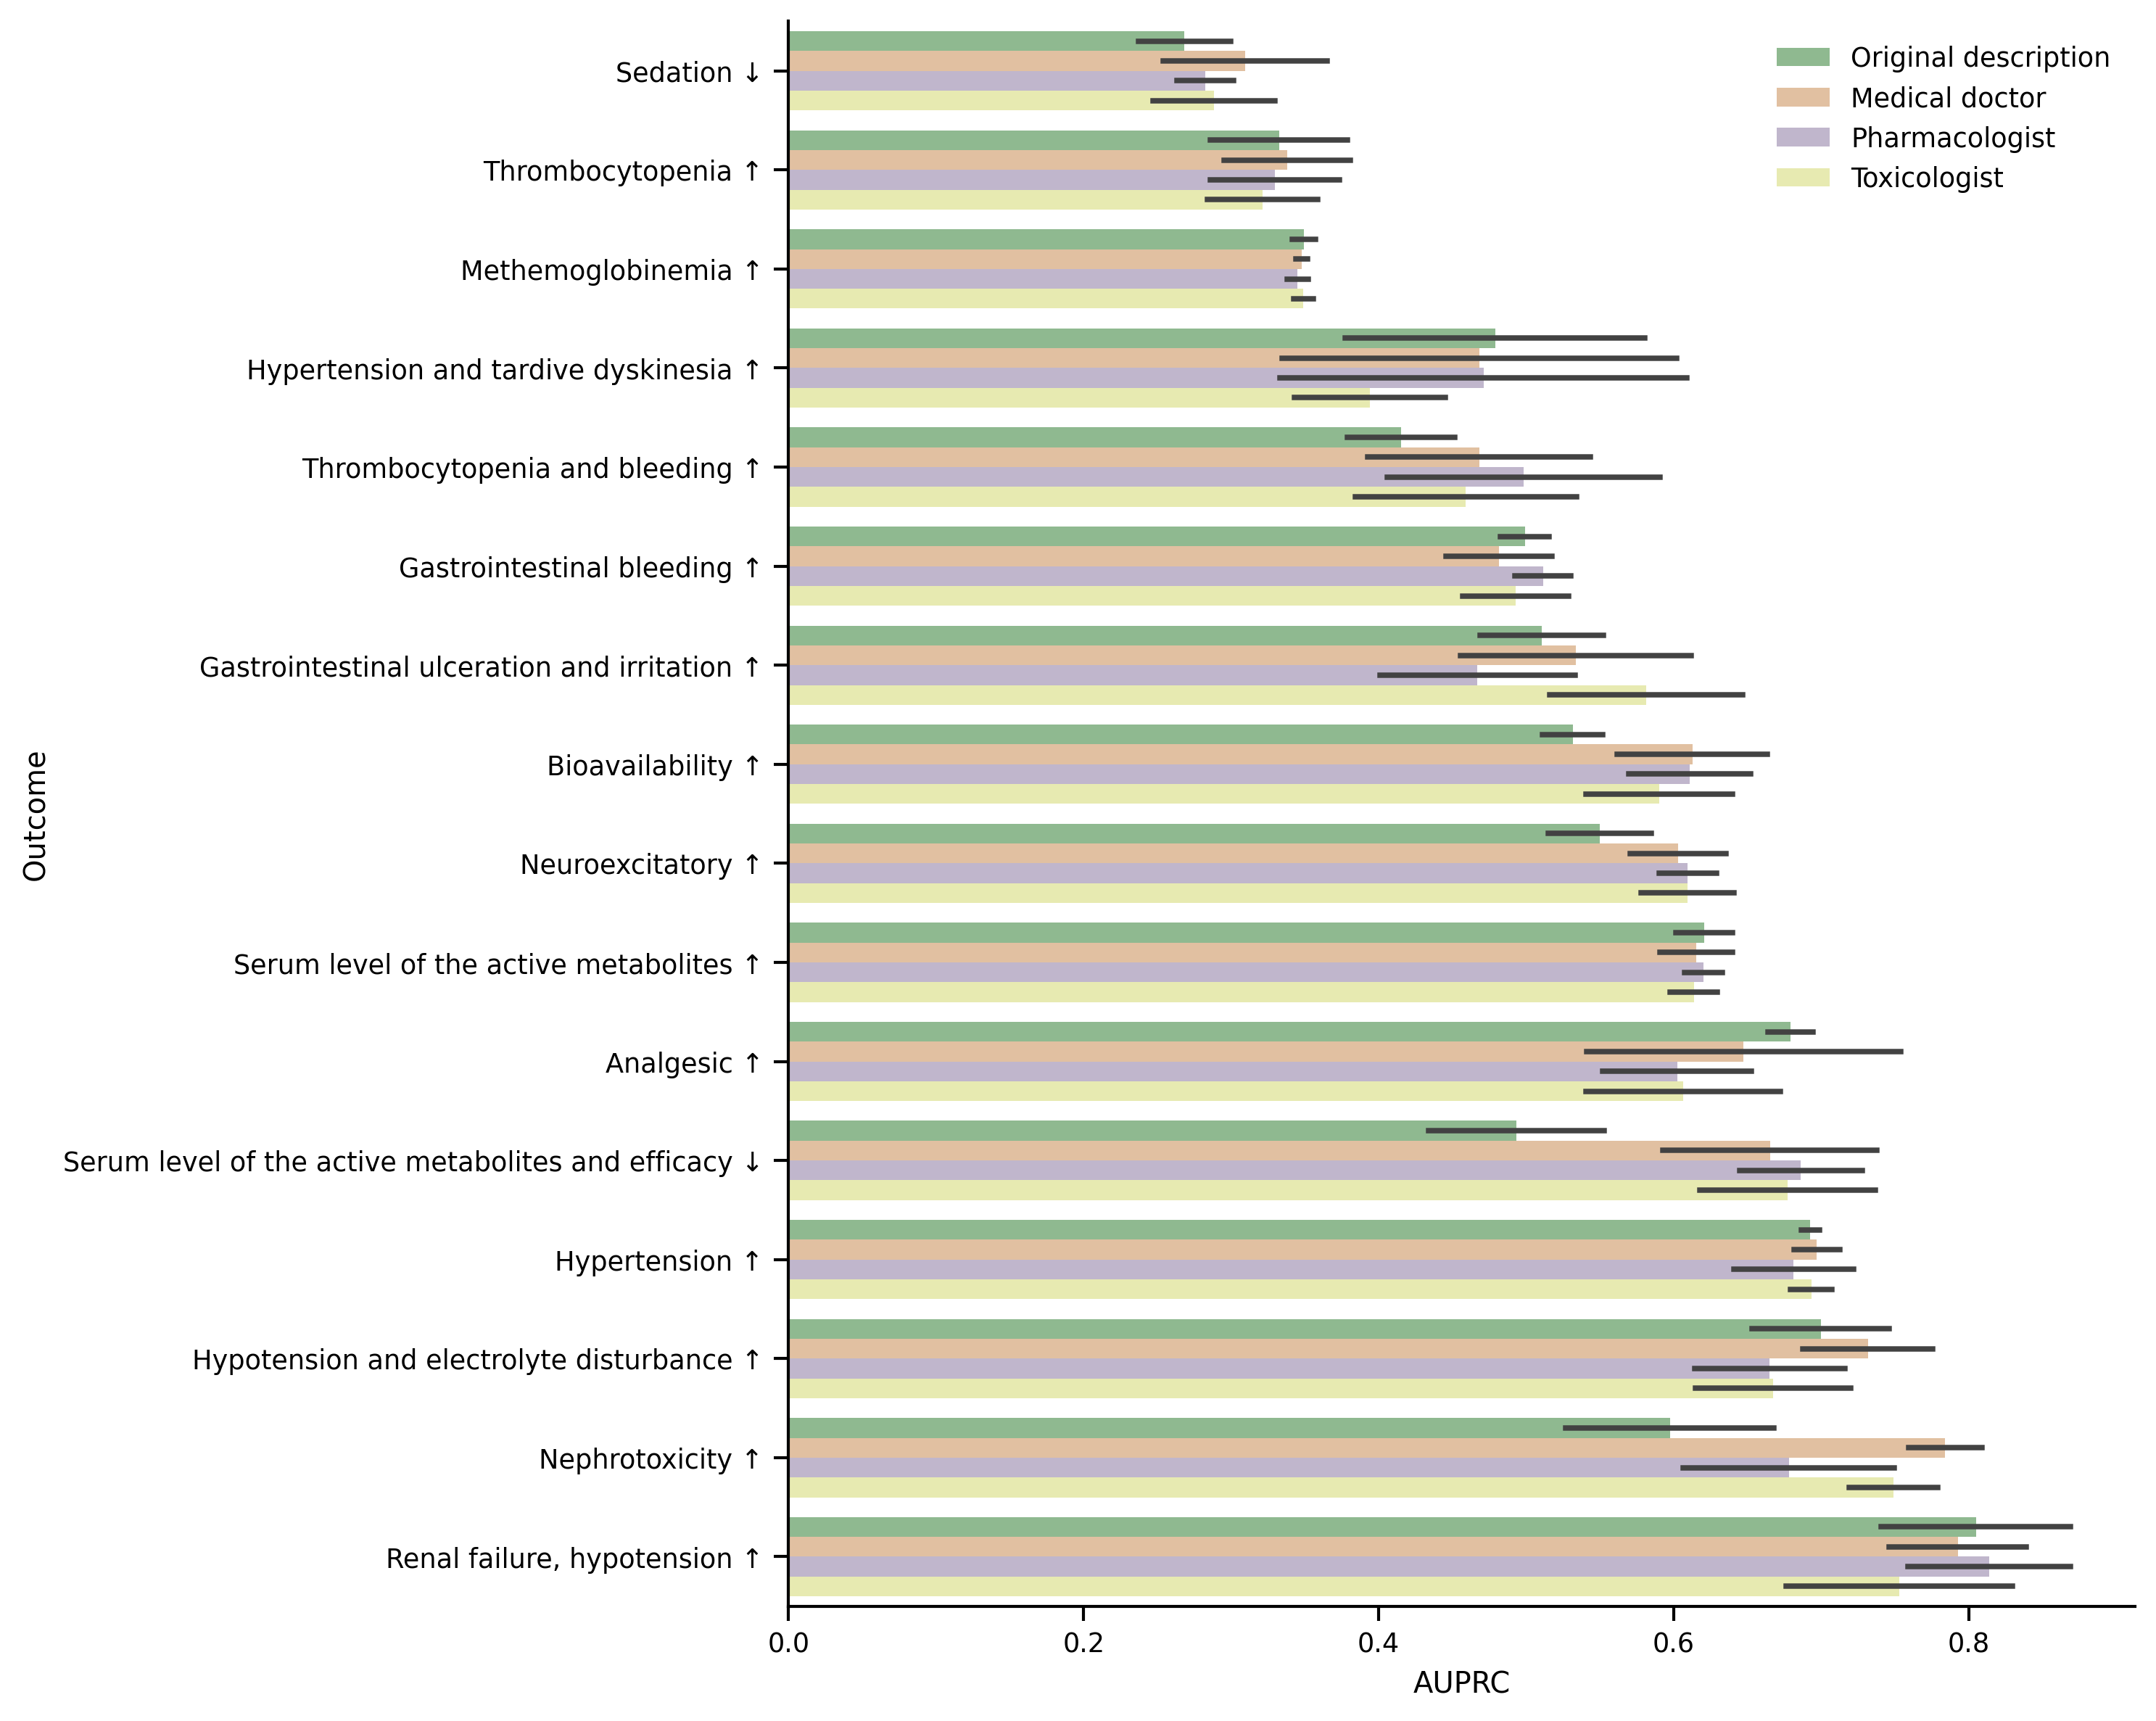

In [25]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=300)

result = df_2.groupby(["Outcome"])['AUPRC'].aggregate(np.mean).reset_index().sort_values('AUPRC')

ax = plt.axes()
ax.set_facecolor("white")

sns.set_context(context='paper')
# Create a color palette with subtle, paper-friendly colors
palette = {
    'Original description': '#88c089',    # Morandi green
    'Medical doctor': '#ecc096',         # Subtle purple
    'Pharmacologist': '#c0b3cf',         # Muted rose
    'Toxicologist': '#f0f3a8',           # Orange/brown
}
g = sns.barplot(
    data=df_2.query("label != 'Naive baseline'"),
    errorbar="sd",
    x="AUPRC", y="Outcome", hue="label", palette=palette, order=result['Outcome'])
sns.despine()
sns.axes_style()
plt.legend(frameon=False, loc = "best")
plt.tight_layout()

# plt.savefig('performance_paraphrased_rep_sns.pdf')

## Concordance with original

In [ ]:
eval_df = pd.read_csv(BASE_DIR+'model_output/lm_decoder/paraphrased_dataset_new/eval_df.csv')
pos_neg = eval_df['pos_neg'].values
labels = eval_df['labels'].values
unique_desc_df = description_df.drop_duplicates(subset='label_indexed')
label_to_desc = dict(zip(unique_desc_df['label_indexed'].values, 
                         unique_desc_df['label'].values))
unique_labels_desc = [label_to_desc[l] for l in np.unique(labels)]

In [27]:
normalized_ranks = np.load(BASE_DIR + 'model_output/DrugBank/split_by_pairs/full_full_all_ddi_DrugBank_nash_drugs_normalized_ranks_700_5_runs_gmean.npy')
normalized_ranks_eval = normalized_ranks[eval_df['labels'].values, eval_df['head'].values, eval_df['tail'].values]
# np.save('./paraphrased_dataset_new/bl_scores.npy', normalized_ranks_eval)

In [ ]:
def get_correlation(run, epoch):
    
    eval_scores_bl = np.load(BASE_DIR+'model_output/lm_decoder/paraphrased_dataset_new/bl_scores.npy')
    
    labels = eval_df['labels'].values
    
    all_corrs = []
    all_pvals = []
    
    for i in tqdm(range(10)):
        eval_scores_lm = np.load(BASE_DIR+f'model_output/lm_decoder/{run}/eval_raw_scores_{epoch}_description_{i}.npy')
        corrs = []
        p_vals = []
        for lab in np.unique(labels):
            msk = labels == lab
            bl_scores = eval_scores_bl[msk]
            lm_scores = eval_scores_lm[msk]
            res = spearmanr(bl_scores, lm_scores)
            corrs.append(res[0])
            p_vals.append(res[1])
        
        all_corrs.append(corrs)
        all_pvals.append(p_vals)
        
    return np.array(all_corrs), np.array(all_pvals)

def plot_stratified_corr(runs, epoch):
    
    all_auprc_repeat = []
    all_pvals_repeat = []
    
    for run in runs:
        all_auprc, all_pvals = get_correlation(run, epoch)
        all_auprc_repeat.append(all_auprc)
        all_pvals_repeat.append(all_pvals)
        
    all_auprc_repeat = np.array(all_auprc_repeat)
    all_pvals_repeat = np.array(all_pvals_repeat)
    
    
    return all_auprc_repeat, all_pvals_repeat
    

In [29]:
all_corrs_repeat, all_pvals_repeat = plot_stratified_corr(runs_mistral, epoch)

100%|██████████| 10/10 [00:00<00:00, 13.36it/s]


In [30]:
dfs = []
for i in range(3):
    
    label = ['Original description']*16 + ['Medical doctor']*48 + ['Pharmacologist']*48 + ['Toxicologist']*48
    
    dfs.append(pd.DataFrame({'Rank correlation': all_corrs_repeat[i,:,:].reshape(160),
                             'p-value': all_pvals_repeat[i,:,:].reshape(160),
                             'Outcome': np.concatenate([new_desc]*10),
                             'label': label}))

In [31]:
df_3 = pd.concat(dfs)
# df_3.to_csv('./plot_5c.csv')

In [32]:
def filter_groups(group):
    return group['p-value'].le(0.05).all()

df_3 = df_3.groupby(['Outcome', 'label']).filter(filter_groups)

In [33]:
def delete_group(group):
    return group[group['p-value'] > 0.05].shape[0] >= 6
groups_to_delete = df_3.groupby(['Outcome', 'label']).filter(delete_group)
indices_to_delete = groups_to_delete.index
df_3 = df_3.drop(indices_to_delete)

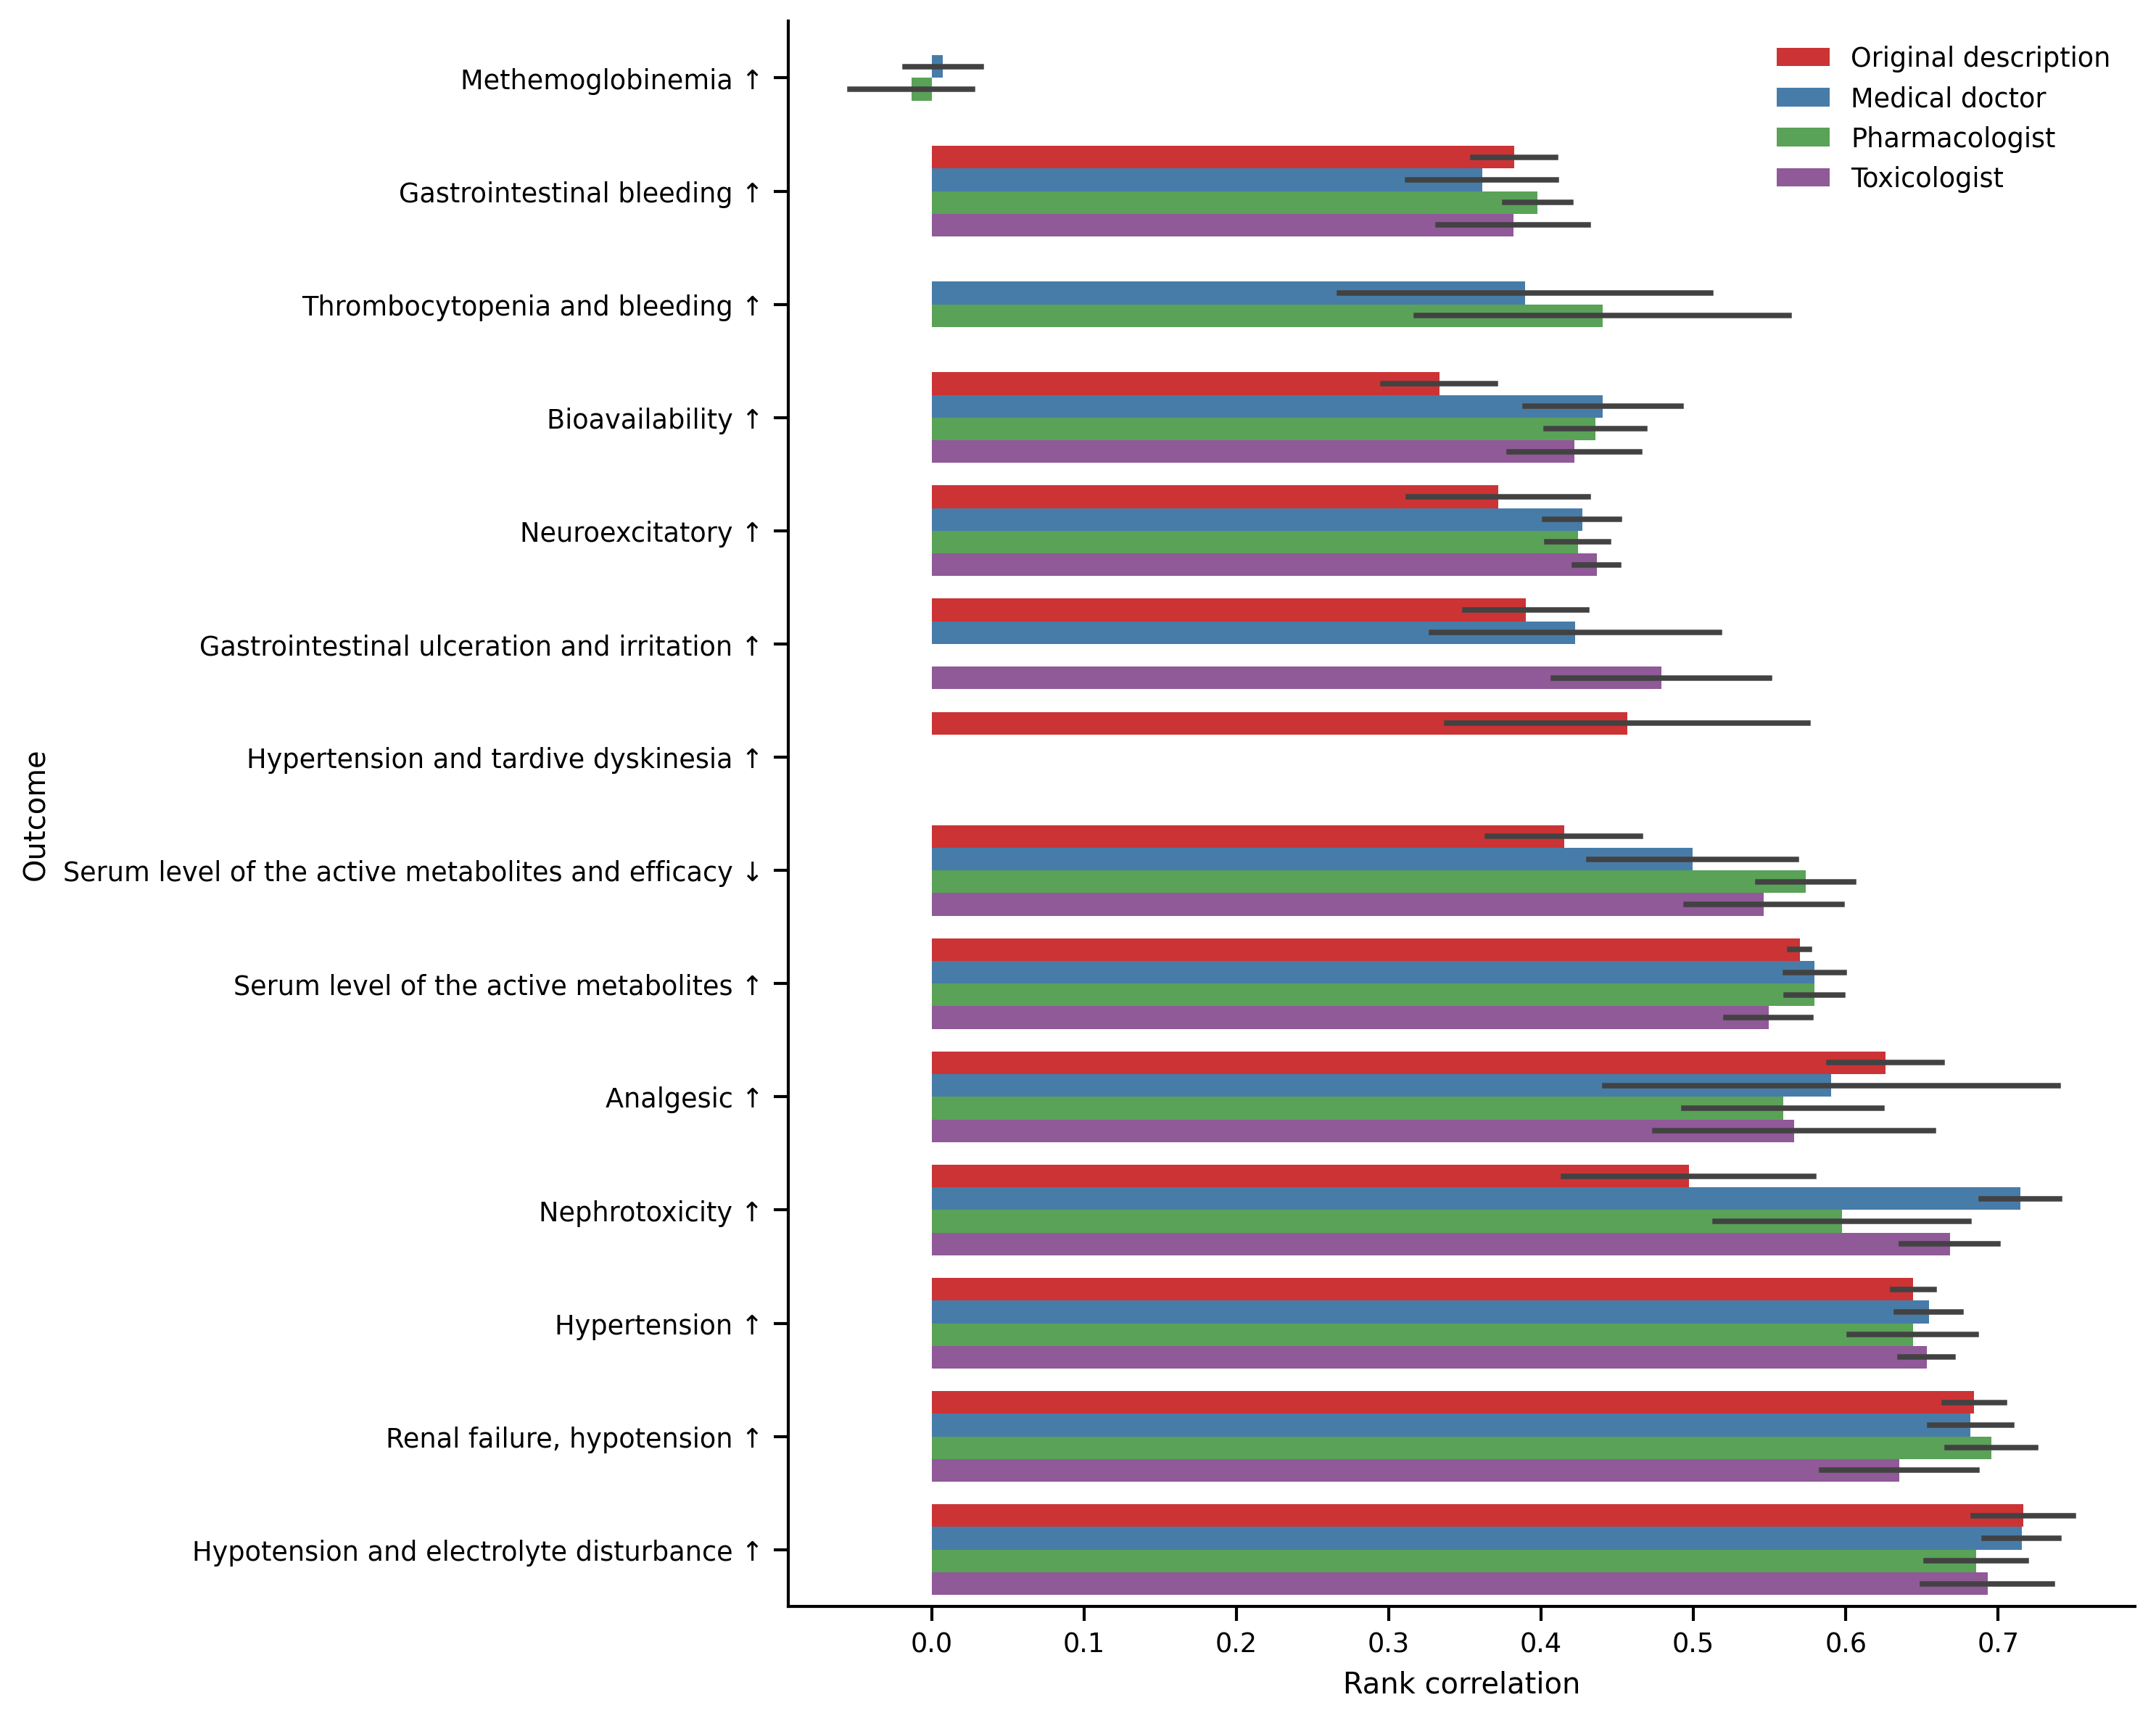

In [34]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=300)

result = df_3.groupby(["Outcome"])['Rank correlation'].aggregate(np.mean).reset_index().sort_values('Rank correlation')

ax = plt.axes()
ax.set_facecolor("white")

sns.set_context(context='paper')
g = sns.barplot(
    data=df_3,
    errorbar="sd",
    x="Rank correlation", y="Outcome", hue="label", palette="Set1", order=result['Outcome'])
sns.despine()
sns.axes_style()
plt.legend(frameon=False, loc = "best")
plt.tight_layout()

# plt.savefig('concordance_paraphrased_rep_sns.svg', format="svg", dpi=300)